In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import csv


In [65]:
df = pd.read_csv('data/ame2020.csv')

data_dict = {}
data_z_12_50 = {}
data_full = {}
data_all_z_12 = {}
for n,z,be,be_unc in zip(df.n,df.z,df.binding,df.binding_unc):
    if (be_unc * (z + n) > 100):
        continue
    if (n>20 and z>20):
        data_dict[(n,z)]=be
    if (z>=12 and z<=50):
        data_z_12_50[(n,z)]=be
    if (z>=12):
        data_all_z_12[(n,z)]=be
    data_full[(n,z)]=be
    
with open('data/reranked_pcs_with_data.csv', newline='') as f:
    reader = csv.reader(f)
    full_features_Z = np.array([float(i) for i in next(reader)])
    full_features_N = np.array([float(i) for i in next(reader)])
    ouail_data = np.array([float(i[1:-1]) for i in next(reader)])
    full_pc0 = np.array([float(i[1:-1]) for i in next(reader)])
    full_pc2 = np.array([float(i[1:-1]) for i in next(reader)])
    full_pc1 = np.array([float(i[1:-1]) for i in next(reader)])

N = []
Z = []
pc0 = []
pc2 = []
pc1 = []
fixed_data = []

Z_z_12_50 = []
N_z_12_50 = []
fixed_data_z_12_50 = []

Z_full = []
N_full = []
fixed_data_full = []
pc0_full = []
pc1_full = []
pc2_full = []

Z_all_z_12 = []
N_all_z_12 = []
fixed_data_all_z_12 = []

for n, z, pc_0, d, pc_2, pc_1 in zip(full_features_N,full_features_Z,full_pc0, ouail_data, full_pc2, full_pc1):
    if (n,z) in data_dict.keys():
        N.append(n)
        Z.append(z)
        pc0.append(pc_0)
        fixed_data.append(d)
        pc2.append(pc_2)
        pc1.append(pc_1)
    if (n,z) in data_z_12_50.keys():
        N_z_12_50.append(n)
        Z_z_12_50.append(z)
        fixed_data_z_12_50.append(d)
    if (n,z) in data_full.keys():
        N_full.append(n)
        Z_full.append(z)
        fixed_data_full.append(d)
        pc0_full.append(pc_0)
        pc1_full.append(pc_1)
        pc2_full.append(pc_2)   
    if (n,z) in data_all_z_12.keys():
        Z_all_z_12.append(z)
        N_all_z_12.append(n)
        fixed_data_all_z_12.append(d)

N = np.array(N)
Z = np.array(Z)
pc0 = np.array(pc0)
pc2 = np.array(pc2)
pc1 = np.array(pc1)
pc0_over_1000000 = pc0/1000000
pc2_over_1000000 = pc2/1000000
pc1_over_1000000 = pc1/1000000
fixed_data = np.array(fixed_data)
fixed_data_over_1000000 = fixed_data/1000000

N_z_12_50 = np.array(N_z_12_50)
Z_z_12_50 = np.array(Z_z_12_50)
fixed_data_z_12_50 = np.array(fixed_data_z_12_50)
fixed_data_z_12_50_over_1000000 = fixed_data_z_12_50/1000000

N_full = np.array(N_full)
Z_full = np.array(Z_full)
fixed_data_full = np.array(fixed_data_full)
fixed_data_full_over_1000000 = fixed_data_full/1000000

N_all_z_12 = np.array(N_all_z_12)
Z_all_z_12 = np.array(Z_all_z_12)
fixed_data_all_z_12 = np.array(fixed_data_all_z_12)
fixed_data_all_z_12_over_1000000 = fixed_data_all_z_12/1000000


In [66]:
@np.vectorize
def valence(x):
    magic = [2,8,20,28,50,82,126,184]
    if x in magic:
        return 0
    else:
        residual = x
        for i in magic:
            if np.abs(i-x) < np.abs(residual):
                residual = np.abs(i-x)
        return residual

v_ns = {}
for n in N:
    v_ns[n] = valence(n)
v_zs = {}
for z in Z:
    v_zs[z] = valence(z)

v_ns_z_12_50 = {}
for n in N_z_12_50:
    v_ns_z_12_50[n] = valence(n)
v_zs_z_12_50 = {}
for z in Z_z_12_50:
    v_zs_z_12_50[z] = valence(z)

v_ns_full = {}
for n in N_full:
    v_ns_full[n] = valence(n)
v_zs_full = {}
for z in Z_full:
    v_zs_full[z] = valence(z)

v_ns_all_z_12 = {}
for n in N_all_z_12:
    v_ns_all_z_12[n] = valence(n)
v_zs_all_z_12 = {}
for z in Z_all_z_12:
    v_zs_all_z_12[z] = valence(z)

In [67]:
@np.vectorize
def pairing(Z, N, aP):
    A = Z + N
    delta = aP * A ** (-1 / 2)
    # delta[(Z % 2 == 1) & (N % 2 == 1)] *= -1
    if (Z % 2 == 1) and (N % 2 == 1):
        delta *= -1
    # delta[A % 1 == 1] = 0
    if (A % 1 == 1):
        delta = 0
    return delta

def volume(Z, N, aV):
    A = Z + N
    return aV * A

def surface(Z, N, aS):
    A = Z + N
    return aS * A ** (2 / 3)

def coulomb(Z, N, aC):
    A = Z + N
    return aC * Z * (Z - 1) / (A ** (1 / 3))

def asymmetry(Z, N, aA):
    A = Z + N
    return aA * (N - Z) ** 2 / A

def rms(one, two):
    return np.sqrt(np.mean((one - two) ** 2))

def shell_helper(Z, N, aN, c1n, c2n, aZ, c1z, c2z, c3n, c3z, c4n, c4z):
    x_n = v_ns_all_z_12[N] - aN
    x_z = v_zs_all_z_12[Z] - aZ
    res = c1n*x_n + c2n*x_n**2 + c3n*x_n**3 + c4n*x_n**4
    res += c1z*x_z + c2z*x_z**2 + c3z*x_z**3 + c4z*x_z**4
    return res

def shifted_piecewise_piecewise_shell(Z, N, args):
    a1z, a2z, a3z, a4z, a1n, a2n, a3n, a4n, b1z, b2z, b3z, b4z, b1n, b2n, b3n, b4n, c1z, c2z, c3z, c4z, c1n, c2n, c3n, c4n, d1z, d2z, d3z, d4z, d1n, d2n, d3n, d4n, e1n, e2n, e3n, e4n, aN1, aN2, aN3, aN4, aN5, aZ1, aZ2, aZ3, aZ4 = args
    res = []
    for n,z in zip(N, Z):
        args = []
        if n<28:
            args.extend([aN1, a1n, a2n, a3n, a4n])
        elif n<50:
            args.extend([aN2, b1n, b2n, b3n, b4n])
        elif n<82:
            args.extend([aN3, c1n, c2n, c3n, c4n])
        elif n<126:
            args.extend([aN4, d1n, d2n, d3n, d4n])
        else:
            args.extend([aN5, e1n, e2n, e3n, e4n])

        if z<28:
            args.extend([aZ1, a1z, a2z, a3z, a4z])
        elif z<50:
            args.extend([aZ2, b1z, b2z, b3z, b4z])
        elif z<82:
            args.extend([aZ3, c1z, c2z, c3z, c4z])
        else:
            args.extend([aZ4, d1z, d2z, d3z, d4z])
        res.append(shell_helper(z, n, *args))
    return res

def double_power_law(x, args):
    a1, b1, c1, d1, a2, b2, c2, d2 = args
    x = np.float64(x)
    b1 = np.clip(b1, -1000, 1000)  # Example range, adjust as needed
    b2 = np.clip(b2, -1000, 1000)  # Example range, adjust as needed

    c1 = np.clip(c1, -10, 10)  # Example range, adjust as needed
    c2 = np.clip(c2, -10, 10)  # Example range, adjust as needed
    return a1 * np.sign(x-b1) * (np.abs(x-b1)) ** c1 + d1 + a2 * np.sign(x-b2) * (np.abs(x-b2)) ** c2 + d2

def fit_pc2_double_power_law_exp_diff(X, args):
    a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, d3 = args
    Z, N = X
    b1 = np.clip(b1, -1000, 1000)  # Example range, adjust as needed
    b2 = np.clip(b2, -1000, 1000)  # Example range, adjust as needed

    c1 = np.clip(c1, -10, 10)  # Example range, adjust as needed
    c2 = np.clip(c2, -10, 10)  # Example range, adjust as needed
    dbl_pwr_law = a1 * np.sign(Z-b1) * (np.abs(Z-b1)) ** c1 + d1 + a2 * np.sign(Z-b2) * (np.abs(Z-b2)) ** c2 + d2
    exp_i = a3 * np.exp(b3 * (N-Z-c3)) + d3
    return dbl_pwr_law + exp_i


In [68]:
def magic_nums_exp(N, Z, args):
    a1, b1, c1, a2, b2, c2 = args
    d1 = np.sqrt((N-82)**2 + (Z-50)**2)
    d2 = np.sqrt((N-126)**2 + (Z-82)**2)
    res = a1*np.exp(-b1*d1 + c1)
    res += a2*np.exp(-b2*d2 + c2)
    return res

@np.vectorize
def ws3_pairing(N, Z, aP2):
    A = N+Z
    res = aP2*A**(-1/3)
    I = np.abs(N-Z)/A
    if (N%2)==0 and (Z%2)==0:
        res *= 2-I
    elif (N%2)==1 and (Z%2)==1:
        res *= I
    elif (N%2)==0 and (Z%2)==1 and N>Z:
        res *= 1-I
    elif (N%2)==1 and (Z%2)==0 and N<Z:
        res *= 1-I
    return res

def terms_so_far_modified(X, *args):
    Z, N = X
    res = 0
    res += volume(Z, N, args[0])
    res += surface(Z, N, args[1])
    res += coulomb(Z, N, args[2])
    res += asymmetry(Z, N, args[3])
    res += ws3_pairing(Z, N, args[4])
    res += shifted_piecewise_piecewise_shell(Z, N, args[5:50])
    
    T = N-Z
    res += args[50]*T**4 + args[51]*T**3 + args[52]*T**2 + args[53]*T + args[54]
    
    pc1_m_fit = double_power_law(Z, args[55:63])
    pc1_b_fit = double_power_law(Z, args[63:71])
    res += pc1_m_fit*T + pc1_b_fit
    
    res += fit_pc2_double_power_law_exp_diff(X, args[71:83])
    
    res += magic_nums_exp(N, Z, args[83:89])

    return res

p0 = [ 2.70999663e-02, -3.53158705e-03, -8.00092888e-04, -1.79821711e-02,
  6.16155256e-03, -2.11798211e-07,  6.28688584e-08,  1.41457265e-08,
 -1.52984835e-10,  1.00130449e-02, -1.62150727e-04,  8.06443041e+01,
  4.64977873e-03, -7.00837006e-07,  5.15854079e-08,  1.91165961e-08,
 -2.39521278e-10,  3.96404069e-02, -4.02509558e-04, -1.40668189e+02,
 -1.40022701e-02, -8.16910293e-07, -5.03720992e-06, -1.19110397e-08,
  1.11195503e-07, -5.43583949e-04,  3.22779642e-05,  8.75357217e-01,
 -6.91426411e-04, -1.23969859e-06, -3.47538006e-06, -1.67663536e-09,
  6.40624849e-08, -3.32060917e-04,  3.60513011e-05, -1.61419957e+00,
 -6.04175845e-04, -1.20767628e-03,  8.07514597e-05,  5.88651610e+00,
 -1.29477437e-04, -5.51794624e+01, -6.71649614e+01,  3.64308862e+00,
  3.57154505e+00, -3.68648758e+00,  3.96988125e-05,  4.54414390e-05,
  8.44327904e-05,  4.86835465e-05, -3.44867582e-08, -6.28279516e-07,
 -2.67564925e-04, -1.05081070e-02, -1.74316184e-01,  1.60418902e-04,
  1.70014028e+01,  2.22976869e-01, -1.04826142e-02,  1.96008679e-06,
  3.45649906e+01,  1.35989930e+00, -1.04966698e-02, -6.97820151e-02,
 -2.34942557e+00,  7.91836535e-01, -1.76891810e-01, -9.96698331e-03,
  1.70044862e+01,  9.24082566e-01, -1.75386859e-01, -3.53468193e-03,
  1.18520465e+01,  4.23379128e-01, -1.76930021e-01,  2.00060355e-01,
 -3.96436801e+00,  3.78545697e-01, -1.74808796e-01,  2.10899345e-01,
  2.67440457e-02, -4.06900826e+01, -1.76029126e-01,  1.24637820e-01,
  1.83184766e-01, -2.50870875e+00,  1.74071569e-02,  8.42830339e-02,
 -2.46429681e-01]

# p0 = [0]*89
popt, pcov = curve_fit(terms_so_far_modified, (Z_all_z_12,N_all_z_12), fixed_data_all_z_12_over_1000000, p0, maxfev=10000000)
print(popt)


[ 2.72552689e-02 -3.13595014e-03 -8.07749039e-04 -1.79574015e-02
  6.17135922e-03 -1.97254413e-07  6.84245881e-08  1.38285968e-08
 -1.75484996e-10  1.03461670e-02 -1.65646375e-04  8.66312394e+01
  4.70420604e-03 -6.75587699e-07  6.02966191e-08  1.86094407e-08
 -2.62714399e-10  4.10688650e-02 -4.10441667e-04 -1.44105302e+02
 -1.44548553e-02 -8.08876644e-07 -5.02146064e-06 -1.23419835e-08
  1.10225962e-07 -5.39453637e-04  3.20024002e-05  8.40342268e-01
 -6.93675520e-04 -1.24075603e-06 -3.38703029e-06 -1.73494856e-09
  6.07307415e-08 -3.32403270e-04  3.60762505e-05 -1.61367005e+00
 -6.03233557e-04 -1.20997809e-03  8.08974995e-05  5.93685734e+00
 -1.25541032e-04 -5.61977259e+01 -6.84235364e+01  3.68781576e+00
  3.57405837e+00 -3.66425245e+00  3.98188923e-05  4.51945874e-05
  8.44700264e-05  4.79755271e-05 -3.45066067e-08 -6.23211518e-07
 -2.67781653e-04 -1.05885372e-02 -1.70591875e-01  1.63595243e-04
  1.70011144e+01  2.29696025e-01 -1.05629125e-02  1.96002218e-06
  3.44696371e+01  1.35871

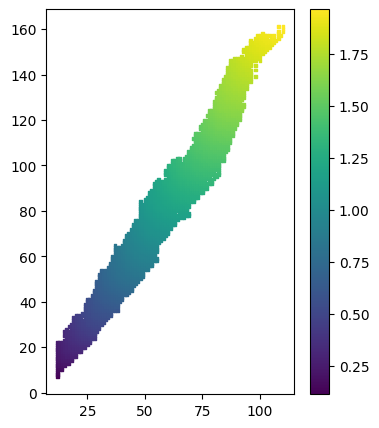

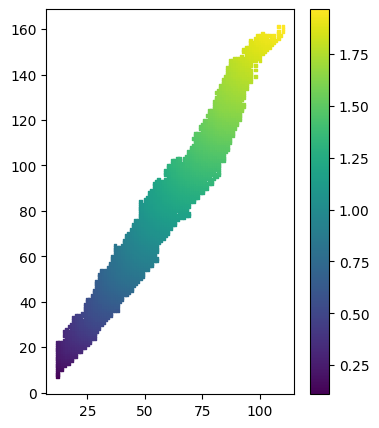

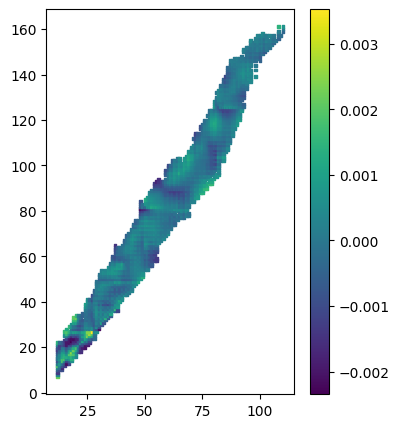

0.5765362224571725

In [69]:
res = terms_so_far_modified((Z_all_z_12,N_all_z_12),*popt)

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000-res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

rms(fixed_data_all_z_12_over_1000000, res)*1000


In [70]:
print(len(popt))
print(max(Z_all_z_12) - min(Z_all_z_12))
print(max(N_all_z_12) - min(N_all_z_12))

89
98.0
154.0


In [73]:
def terms_so_far_modified_for_micro(X, *args):
    args = args[0]
    
    Z, N = X
    res = 0
    res += volume(Z, N, args[0])
    res += surface(Z, N, args[1])
    res += coulomb(Z, N, args[2])
    res += asymmetry(Z, N, args[3])
    res += ws3_pairing(Z, N, args[4])
    res += shifted_piecewise_piecewise_shell(Z, N, args[5:50])
    
    T = N-Z
    res += args[50]*T**4 + args[51]*T**3 + args[52]*T**2 + args[53]*T + args[54]
    
    pc1_m_fit = double_power_law(Z, args[55:63])
    pc1_b_fit = double_power_law(Z, args[63:71])
    res += pc1_m_fit*T + pc1_b_fit
    
    res += fit_pc2_double_power_law_exp_diff(X, args[71:83])
    
    res += magic_nums_exp(N, Z, args[83:89])

    return res

def vector_help(Z, N, cN, cZ):
    iZ = Z - 12
    iN = N - 7
    return cN[int(iN)] + cZ[int(iZ)]

def microcorrections(X, *args):
    Z, N = X
    vg = np.vectorize(vector_help, excluded=['cN','cZ'])
    cZ = args[89:188]
    cN = args[188:]
    return vg(Z=Z, N=N, cZ=cZ, cN=cN)+terms_so_far_modified_for_micro(X, args[:89])

p0 = list(popt) + [0]*99 + [0]*155
micro_popt, pcov = curve_fit(microcorrections, (Z_all_z_12,N_all_z_12), fixed_data_all_z_12_over_1000000, p0, maxfev=10000000)
print(micro_popt)

[ 2.72501632e-02 -3.13376687e-03 -8.08965199e-04 -2.01484692e-02
  6.79047244e-03 -3.52599859e-07  7.07827925e-08  1.45419247e-08
 -1.42686006e-10  1.01114807e-02 -1.68134387e-04  1.49974454e+02
  4.87111535e-03 -6.20092890e-07  7.19060332e-08  1.80728482e-08
 -2.37512208e-10  4.09971856e-02 -4.11267362e-04 -1.34516392e+02
 -1.44966920e-02 -3.75522793e-11 -1.01996810e-06  9.24425772e-08
 -1.59060774e-08 -5.64012654e-04  4.55514527e-05  5.20976519e+00
 -2.44581255e-04 -6.71408311e-08  7.57609840e-06  8.26761049e-09
  8.18057160e-07 -3.20303520e-04  4.07384623e-05  7.69221721e+00
  1.97189267e-04 -1.48076987e-03  6.94679766e-05  9.57785942e+00
  3.83560414e-04 -3.95604717e+01 -5.07994817e+01  1.55527813e+01
  1.21087398e+01 -4.69582414e+00  3.97927013e-05  4.46810406e-05
  7.83669343e-05  6.73680784e-05 -3.31480226e-08 -1.21222085e-06
 -2.38023063e-04 -1.05761240e-02 -1.72162114e-01  3.53546952e-05
  1.72503497e+01 -2.02887271e-01 -1.05504987e-02  4.82270619e-07
  2.42936850e+01  1.07745

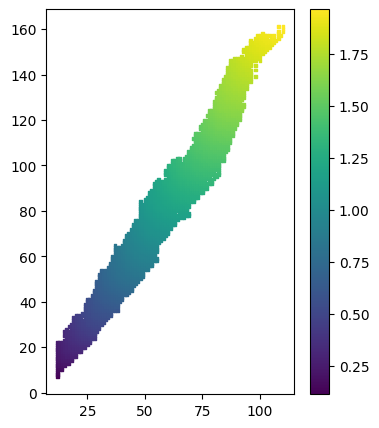

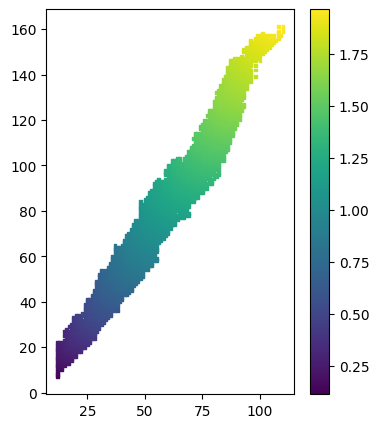

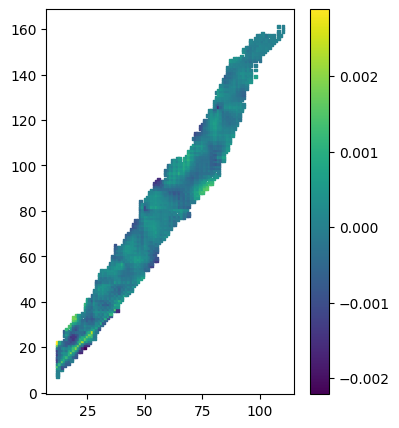

0.43033374107714223

In [74]:
res = microcorrections((Z_all_z_12,N_all_z_12),*micro_popt)

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000-res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

rms(fixed_data_all_z_12_over_1000000, res)*1000


In [75]:
def vector_help_plus_line(Z, N, cN, cZ, cL):
    iZ = Z - 12
    iN = N - 7
    iL = N - 12
    res = cN[int(iN)] + cZ[int(iZ)]
    if (N==Z):
        res += cL[int(iL)]
    return res

def microcorrections_plus_line(X, *args):
    Z, N = X
    vg = np.vectorize(vector_help_plus_line, excluded=['cN','cZ','cL'])
    cZ = args[89:188]
    cN = args[188:343]
    cL = args[343:]
    return vg(Z=Z, N=N, cZ=cZ, cN=cN, cL=cL)+terms_so_far_modified_for_micro(X, args[:89])

p0 = list(micro_popt) + [0]*27
micro_popt_line, pcov = curve_fit(microcorrections_plus_line, (Z_all_z_12,N_all_z_12), fixed_data_all_z_12_over_1000000, p0, maxfev=10000000)
print(micro_popt_line)

[ 2.72502068e-02 -3.13321523e-03 -8.09017348e-04 -2.01635747e-02
  6.38311819e-03 -3.54770034e-07  7.08676777e-08  1.45441016e-08
 -1.43029376e-10  1.01086456e-02 -1.68200499e-04  1.50963640e+02
  4.87188508e-03 -6.19563490e-07  7.18955464e-08  1.80667002e-08
 -2.37470194e-10  4.09967165e-02 -4.11274246e-04 -1.34402938e+02
 -1.44968988e-02 -2.19230243e-09 -1.04907491e-06  9.19552275e-08
 -1.71046181e-08 -5.63070520e-04  4.54712385e-05  5.34364169e+00
 -2.40840078e-04 -6.14617880e-08  7.80215402e-06  8.39851577e-09
  8.24994064e-07 -3.21974267e-04  4.14914433e-05  7.74534054e+00
  1.92353905e-04 -1.48360396e-03  6.93226395e-05  9.60917386e+00
  3.81638848e-04 -3.95486051e+01 -5.08198728e+01  1.55713997e+01
  1.20666560e+01 -4.70989208e+00  3.97952910e-05  4.46717033e-05
  7.91004140e-05  6.96215119e-05 -3.31397583e-08 -1.21133379e-06
 -2.38089308e-04 -1.05721302e-02 -1.72151222e-01  8.87232560e-06
  1.61979535e+01 -2.91914148e-01 -1.05465050e-02  5.14978941e-07
  2.41117985e+01  1.06666

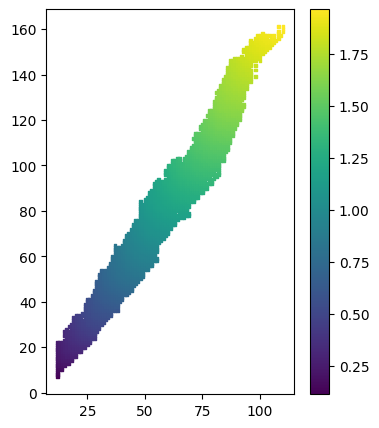

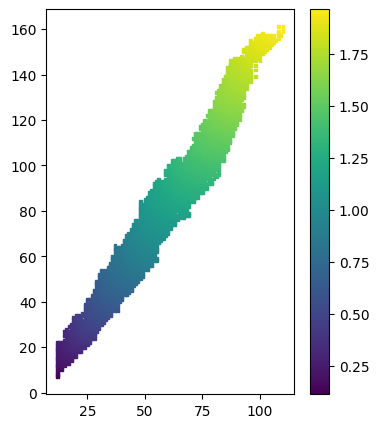

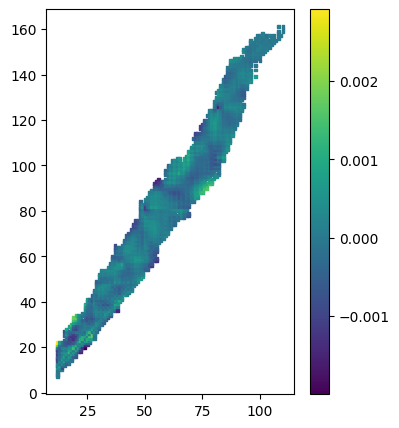

0.3994206723829793

In [76]:
res = microcorrections_plus_line((Z_all_z_12,N_all_z_12),*micro_popt_line)

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000-res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

rms(fixed_data_all_z_12_over_1000000, res)*1000


In [81]:
def line_exp(N, Z, args):
    m, b, pitch, shift = args
    res = []
    for n, z in zip(N, Z):
        if z<28:
            pt_on_line = (n+z)/2
            max_val = linear_fit(pt_on_line, m, b)
            dist = np.sqrt((n-pt_on_line)**2 + (z-pt_on_line)**2)
            res.append(max_val*np.exp(-pitch*dist + shift))
        else:
            res.append(0)
    return res

def terms_so_far_modified_for_micro_plus_line_exp(X, *args):
    args = args[0]
    
    Z, N = X
    res = 0
    res += volume(Z, N, args[0])
    res += surface(Z, N, args[1])
    res += coulomb(Z, N, args[2])
    res += asymmetry(Z, N, args[3])
    res += ws3_pairing(Z, N, args[4])
    res += shifted_piecewise_piecewise_shell(Z, N, args[5:50])
    
    T = N-Z
    res += args[50]*T**4 + args[51]*T**3 + args[52]*T**2 + args[53]*T + args[54]
    
    pc1_m_fit = double_power_law(Z, args[55:63])
    pc1_b_fit = double_power_law(Z, args[63:71])
    res += pc1_m_fit*T + pc1_b_fit
    
    res += fit_pc2_double_power_law_exp_diff(X, args[71:83])
    
    res += magic_nums_exp(N, Z, args[83:89])
    res += line_exp(N, Z, args[89:93])

    return res

def microcorrections_plus_exp_line(X, *args):
    Z, N = X
    vg = np.vectorize(vector_help, excluded=['cN','cZ'])
    cZ = args[93:192]
    cN = args[192:]
    return vg(Z=Z, N=N, cZ=cZ, cN=cN)+terms_so_far_modified_for_micro_plus_line_exp(X, args[:93])

p0 = list(popt) + [0]*4 + [0]*99 + [0]*155
micro_popt_plus_line, pcov = curve_fit(microcorrections_plus_exp_line, (Z_all_z_12,N_all_z_12), fixed_data_all_z_12_over_1000000, p0, maxfev=10000000)
print(micro_popt_plus_line)

[ 2.72826758e-02 -2.84651046e-03 -8.09940064e-04 -1.69843735e-02
  6.21589713e-03 -3.09594720e-07  6.86010304e-08  1.42644393e-08
 -1.75276668e-10  1.01806877e-02 -1.67922581e-04  1.75177118e+02
  4.71269650e-03 -6.50853403e-07  6.97813764e-08  1.80528907e-08
 -2.51196433e-10  4.09711425e-02 -4.11580427e-04 -1.54067475e+02
 -1.45162251e-02  1.16743267e-06 -5.91191739e-07  1.80041953e-07
 -4.98112882e-09  7.12149610e-04 -2.48525149e-05 -5.94149815e-01
  7.49201413e-04  1.14360092e-06  1.30446990e-05  9.57568774e-08
  9.94927543e-07 -4.41858932e-04  2.92749764e-05  8.55640722e+00
  1.62797898e-03  1.72459152e-04  1.09873563e-04  1.03334861e+01
  1.74946040e-03 -5.36451843e+01 -5.78982569e+01  1.36904334e+01
  1.10389575e+01 -5.23059021e+00  3.97954052e-05  4.54202184e-05
  5.54144579e-05  7.61083871e-05 -3.05763354e-08 -1.55343451e-06
 -2.64607997e-04 -1.00353592e-02 -1.71664252e-01  1.21628900e-04
  1.80000015e+01  4.21657356e-01 -1.00097301e-02 -2.80783232e-06
  2.96694364e+01  1.76195

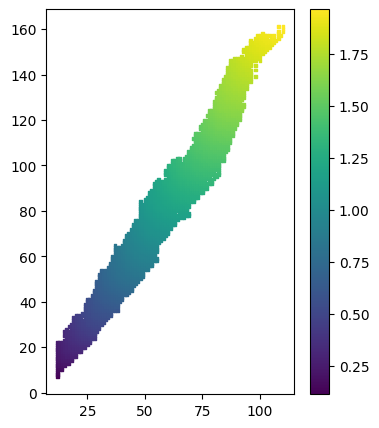

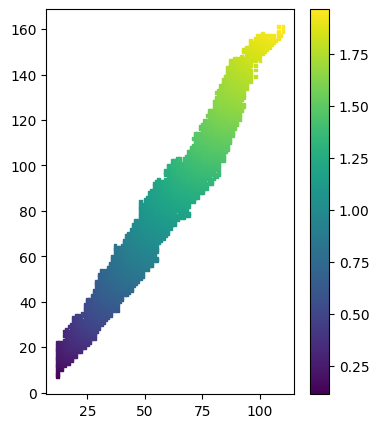

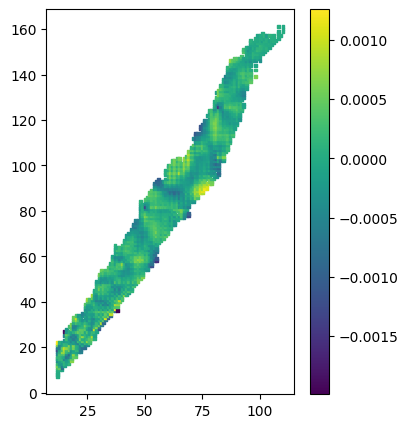

0.330061361243178

In [82]:
res = microcorrections_plus_exp_line((Z_all_z_12,N_all_z_12),*micro_popt_plus_line)

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000-res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

rms(fixed_data_all_z_12_over_1000000, res)*1000


In [83]:
fixed_data_all_z_12_50_over_1000000 = []
res_12_50 = []
for n, z, d, r in zip(N_all_z_12, Z_all_z_12, fixed_data_all_z_12_over_1000000, res):
    if z<=50:
        fixed_data_all_z_12_50_over_1000000.append(d)
        res_12_50.append(r)

fixed_data_all_z_12_50_over_1000000 = np.array(fixed_data_all_z_12_50_over_1000000)
res_12_50 = np.array(res_12_50)

rms(fixed_data_all_z_12_50_over_1000000, res_12_50)*1000


0.33874023926465474

In [85]:
def const_exp(N, Z, args):
    c, pitch, shift = args
    res = []
    for n, z in zip(N, Z):
        if z>27 and z<39:
            pt_on_line = (n+z)/2
            dist = np.sqrt((n-pt_on_line)**2 + (z-pt_on_line)**2)
            res.append(c*np.exp(-pitch*dist + shift))
        else:
            res.append(0)
    return res

def terms_so_far_modified_for_micro_plus_line_plus_const_exp(X, *args):
    args = args[0]
    
    Z, N = X
    res = 0
    res += volume(Z, N, args[0])
    res += surface(Z, N, args[1])
    res += coulomb(Z, N, args[2])
    res += asymmetry(Z, N, args[3])
    res += ws3_pairing(Z, N, args[4])
    res += shifted_piecewise_piecewise_shell(Z, N, args[5:50])
    
    T = N-Z
    res += args[50]*T**4 + args[51]*T**3 + args[52]*T**2 + args[53]*T + args[54]
    
    pc1_m_fit = double_power_law(Z, args[55:63])
    pc1_b_fit = double_power_law(Z, args[63:71])
    res += pc1_m_fit*T + pc1_b_fit
    
    res += fit_pc2_double_power_law_exp_diff(X, args[71:83])
    
    res += magic_nums_exp(N, Z, args[83:89])
    res += line_exp(N, Z, args[89:93])
    res += const_exp(N, Z, args[93:96])

    return res

def microcorrections_plus_exp_line(X, *args):
    Z, N = X
    vg = np.vectorize(vector_help, excluded=['cN','cZ'])
    cZ = args[96:195]
    cN = args[195:]
    return vg(Z=Z, N=N, cZ=cZ, cN=cN)+terms_so_far_modified_for_micro_plus_line_plus_const_exp(X, args[:96])

p0 = list(micro_popt_plus_line) + [0]*3
micro_popt_plus_line_plus_const, pcov = curve_fit(microcorrections_plus_exp_line, (Z_all_z_12,N_all_z_12), fixed_data_all_z_12_over_1000000, p0, maxfev=10000000)
print(micro_popt_plus_line_plus_const)

/var/folders/cp/gwy2srrd3m701_ntyz1r932h0000gn/T/ipykernel_43589/3639107253.py:85: RuntimeWarning: overflow encountered in exp
  exp_i = a3 * np.exp(b3 * (N-Z-c3)) + d3


[ 2.72805824e-02 -2.86230083e-03 -8.09866669e-04 -1.70008913e-02
  6.22081408e-03 -3.16787276e-07  6.86021071e-08  1.44286839e-08
 -1.81031806e-10  1.01796641e-02 -1.67894209e-04  1.76933956e+02
  4.70904168e-03 -6.43392919e-07  6.96178423e-08  1.80192034e-08
 -2.55076977e-10  4.09729150e-02 -4.11469664e-04 -1.56936882e+02
 -1.45175235e-02  1.21266716e-06 -5.02447129e-07  1.86446553e-07
 -4.48737805e-09  5.78781773e-04 -1.02893704e-05 -1.57173870e+00
  7.80882719e-04  1.14831351e-06  1.62209988e-05  1.01743050e-07
  1.13795072e-06 -4.42004253e-04  2.66958401e-06  8.95407419e+00
  1.77560265e-03  2.64293983e-04  1.08070387e-04  1.05127948e+01
  1.85694717e-03 -5.33711296e+01 -5.85477774e+01  1.35288933e+01
  1.11397803e+01 -4.91809633e+00  3.98874119e-05  4.53401431e-05
  5.41568139e-05  8.75565451e-05 -3.14028906e-08 -1.54612568e-06
 -2.68699790e-04 -1.00804935e-02 -1.71913783e-01  1.25750525e-04
  1.80000055e+01  3.65046911e-01 -1.00548681e-02 -2.47644144e-06
  2.98059853e+01  1.78696

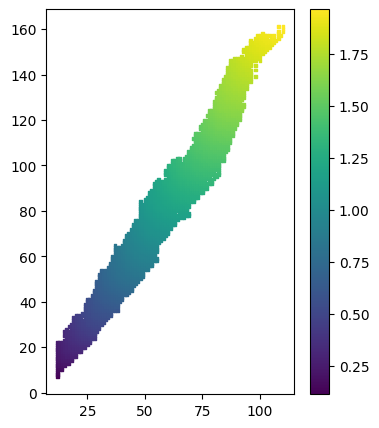

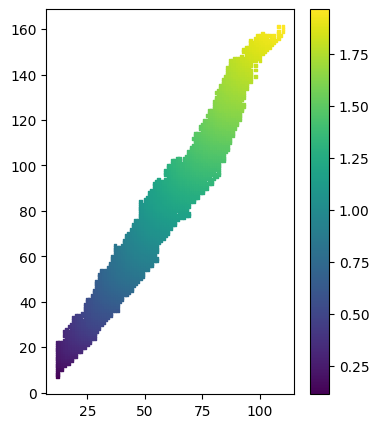

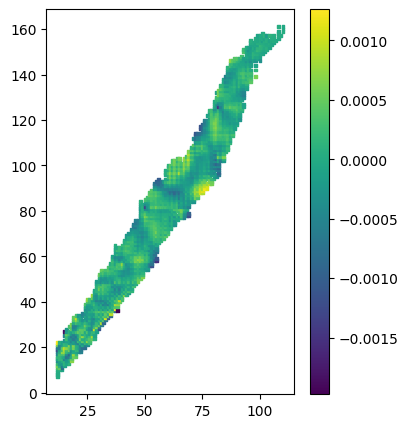

0.3294266737905471

In [86]:
res = microcorrections_plus_exp_line((Z_all_z_12,N_all_z_12),*micro_popt_plus_line_plus_const)

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(Z_all_z_12, N_all_z_12, c=fixed_data_all_z_12_over_1000000-res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

rms(fixed_data_all_z_12_over_1000000, res)*1000


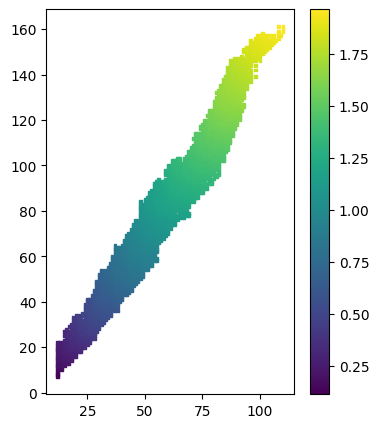

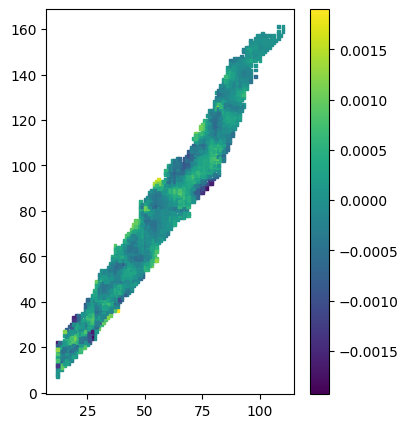

0.3987315336430419


In [63]:
micro_fits_ns = []
micro_fits_zs = []
micro_fits_res = []
with open('data/one-removed-test-results.txt', 'r') as file:
    for line in file:
        pair = line.strip().replace('[', '').replace(']', '').replace(',', '').split()
        micro_fits_ns.append(int(float(pair[0])))
        micro_fits_zs.append(int(float(pair[1])))
        micro_fits_res.append(float(pair[2]))

plt.figure(figsize=(4,5))
plt.scatter(micro_fits_zs, micro_fits_ns, c=micro_fits_res, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

micro_fits_err = []
data_for_micro_comparison = []
for i in range(len(micro_fits_res)):
    for j in range(len(fixed_data_all_z_12_over_1000000)):
        if micro_fits_ns[i]==N_all_z_12[j] and micro_fits_zs[i]==Z_all_z_12[j]:
            micro_fits_err.append(micro_fits_res[i]-fixed_data_all_z_12_over_1000000[j])
            data_for_micro_comparison.append(fixed_data_all_z_12_over_1000000[j])

data_for_micro_comparison = np.array(data_for_micro_comparison)
micro_fits_res = np.array(micro_fits_res)

plt.figure(figsize=(4,5))
plt.scatter(micro_fits_zs, micro_fits_ns, c=micro_fits_err, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

print(rms(data_for_micro_comparison, micro_fits_res)*1000)

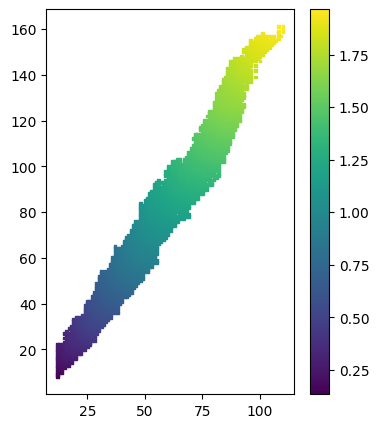

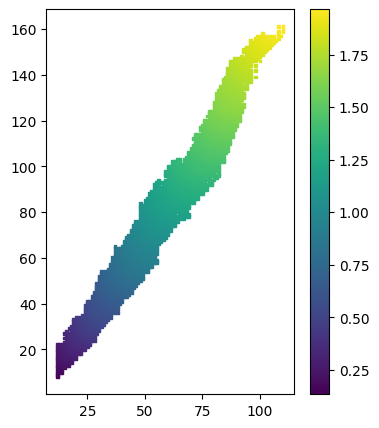

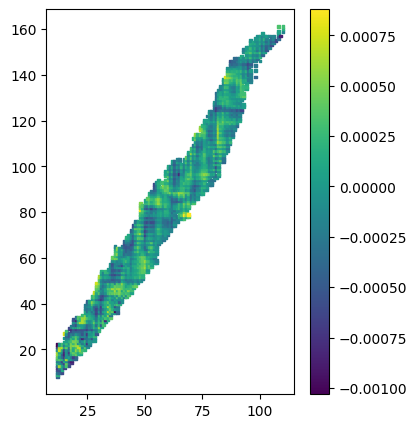

0.2791214392716552


In [48]:
Da = 931.494102
mp = 938.78307
mn = 939.56542

ws4_as = []
ws4_zs = []
ws4_bea_err = []
ws4_ns = []
with open('data/WS4.txt', 'r') as file:
    for line in file:
        pair = line.strip().replace('[', '').replace(']', '').replace(',', '').split()
        ws4_as.append(int(float(pair[0])))
        ws4_zs.append(int(float(pair[1])))
        ws4_bea_err.append(float(pair[2]))
        ws4_ns.append(ws4_as[-1]-ws4_zs[-1])

ws4_ns_filtered = []
ws4_zs_filtered = []
test_ws4_col = []
ws4_pred_be = []
data_for_ws4 = []
ws4_err = []
for i in range(len(ws4_as)):
    for j in range(len(fixed_data_all_z_12_over_1000000)):
        if ws4_zs[i]==Z_all_z_12[j] and ws4_ns[i]==N_all_z_12[j]:
            ws4_ns_filtered.append(ws4_ns[i])
            ws4_zs_filtered.append(ws4_zs[i])
            temp = ws4_zs[i] * mp + ws4_ns[i] * mn - ws4_bea_err[i] - ws4_as[i] * Da
            test_ws4_col.append(temp/1000)
            # data_bea = fixed_data_all_z_12_over_1000000[j]*1000000/ws4_as[i]
            # ws4_pred_bea = data_bea+ws4_bea_err[i]
            # ws4_pred_be.append(ws4_pred_bea*ws4_as[i])
            data_for_ws4.append(fixed_data_all_z_12_over_1000000[j])
            # ws4_err.append(ws4_pred_be[-1]-data_for_ws4[-1])

# ws4_pred_be_over_1000000 = np.array(ws4_pred_be)/1000000
# ws4_err_over_1000000 = np.array(ws4_err)/1000000
# data_for_ws4_over_1000000 = np.array(data_for_ws4)/1000000

# plt.figure(figsize=(4,5))
# plt.scatter(ws4_zs_filtered, ws4_ns_filtered, c=ws4_pred_be_over_1000000, cmap="viridis", s=4, marker="s")
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(4,5))
# plt.scatter(ws4_zs_filtered, ws4_ns_filtered, c=ws4_err_over_1000000, cmap="viridis", s=4, marker="s")
# plt.colorbar()
# plt.show()

plt.figure(figsize=(4,5))
plt.scatter(ws4_zs_filtered, ws4_ns_filtered, c=test_ws4_col, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

plt.figure(figsize=(4,5))
plt.scatter(ws4_zs_filtered, ws4_ns_filtered, c=data_for_ws4, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

test_ws4_col = np.array(test_ws4_col)
data_for_ws4 = np.array(data_for_ws4)

plt.figure(figsize=(4,5))
plt.scatter(ws4_zs_filtered, ws4_ns_filtered, c=test_ws4_col-data_for_ws4, cmap="viridis", s=4, marker="s")
plt.colorbar()
plt.show()

print(rms(np.array(test_ws4_col), np.array(data_for_ws4))*1000)
